In [652]:
import pandas as pd
import numpy as np
import duckdb
import seaborn
import matplotlib.pyplot as plt

#### Correspondance bureaux ==> régiments

Les auteurs rattachent chaque régiment au bureau de recrutement dans lequel il était en garnison.  

En pratique la correspondance n'est pas toujours de un à un. Il y a souvent plusieurs régiments pour un bureau (et vice versa).

In [653]:
df = pd.read_excel("heroes and villains/Original_source_data/Dictionnaire/id_name_bureauxderecrutement_regiment.xlsx",dtype=str)

# On ne garde que les colonnes avec le nom et l'id du bureau et la liste des régiments correspondants
df = df[[i for i in df.columns if any(x in i for x in ["bureau","old"]) and "note" not in i and "_map" not in i]]

#dépivotage pour obtenir la table en format long
df = df.melt(id_vars=["bureau_de_recrutement_dictionnaire","id_bureau"])[["id_bureau","bureau_de_recrutement_dictionnaire","value"]].dropna().drop_duplicates()

df.columns = ["id_bureau","bureau","regiment"]


#comme indiqué dans l'article, l'analyse ne concerne que les régiments de 1 à 144
df_bureau = df[df["regiment"].isin([str(i) for i in range(1,145)])].sort_values(["regiment","bureau"])
df_bureau

,id_bureau,bureau,regiment
0,41,Cambrai,1
59,20,Auxonne,10
220,57,Dijon,10
94,155,Tulle,100
27,58,Dreux,101
...,...,...,...
121,134,Roanne,98
111,88,Lyon (Central),99
105,86,Lyon (annexe Nord) Ile-Barbe,99
115,87,Lyon (annexe Sud) Saint-Just,99


#### Régiments présents à Verdun

Les auteurs indiquent pour chaque régiment et chaque mois de février à décembre 1916 s'il était présent à Verdun.  
La variable VerdunPétain indique simplement si le régiment était présent à Verdun de février à avril.

In [654]:
regim_verdun_data = pd.read_excel("heroes and villains/Original_source_data/Regiments/Verdun/RI_Verdun&OtherBattles.xlsx", dtype=str)

month_dic = {"feb" : "2", "march"  : "3" , "april" : "4",  "mai" : "5",  "june"	 : "6" , "july"  : "7", "aug" : "8",  "sept": "9" , "oct" : "10",  "nov"  : "11", "dec" : "12"}

# On garde les colonnes contenant le numéro du régiment et les colonnes de mois de type booléen
keep_columns = ["RI_number"] + list(month_dic.keys())

#On garde les régiments de 1 à 144 et on dépivote en format long
df_regim_verdun = (
    regim_verdun_data
    .loc[regim_verdun_data["RI_number"].astype("int32")<= 144 ,keep_columns]
    .melt(id_vars=["RI_number"],var_name="mois",value_name="verdun")
    )

#ajout du n° de mois et de l'année pour pouvoir joindre la table plus tard
df_regim_verdun["mois_verdun"] = df_regim_verdun.loc[:,"mois"].replace(month_dic)
df_regim_verdun["annee_verdun"] = "1916"
df_regim_verdun

,RI_number,mois,verdun,mois_verdun,annee_verdun
0,1,feb,1,2,1916
1,2,feb,0,2,1916
2,3,feb,1,2,1916
3,4,feb,0,2,1916
4,5,feb,0,2,1916
...,...,...,...,...,...
1579,140,dec,0,12,1916
1580,141,dec,0,12,1916
1581,142,dec,0,12,1916
1582,143,dec,0,12,1916


#### Bureaux ayant servi à Verdun
On regarde pour chaque bureau s'il a au moins un régiment correspondant qui a été à Verdun

In [655]:
#on récupère les régiments qui ont servi à Verdun sous Pétain et ceux dont ce n'est pas le cas
regiments_petain = regim_verdun_data[["RI_number","verdun_petain"]].drop_duplicates()

##On joint cette table avec celles des bureaux
bureau_petain = df_bureau.merge(regiments_petain,left_on="regiment",right_on="RI_number")[["id_bureau","bureau","verdun_petain"]].drop_duplicates()

#on enlève les bureaux qui ont envoyé des soldats à la fois dans des régiments Pétain et notPétain
remove = bureau_petain.groupby("id_bureau")["verdun_petain"].count()
remove = remove[remove > 1].index
bureau_petain = bureau_petain[~bureau_petain["id_bureau"].isin(remove)].rename(columns={"verdun_petain" : "bureau_verdun_petain"})

bureau_petain

,id_bureau,bureau,bureau_verdun_petain
0,41,Cambrai,1
1,20,Auxonne,0
3,155,Tulle,0
4,58,Dreux,0
10,46,Chartres,0
...,...,...,...
216,74,La Roche-sur-Yon,0
217,35,Bourges,1
218,31,Béziers,0
219,134,Roanne,1


#### Base de données Morts pour la France

On utilise la base de données [Morts pour la France](https://www.memoiredeshommes.sga.defense.gouv.fr/fr/article.php%3Flarub%3D24%26titre%3Dmorts-pour-la-france-de-la-premiere-guerre-mondiale]) dans la version retravaillée par Victor Gay, Pauline Grosjean ([article ici](https://hal.science/hal-04125801/document), [données ici](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/2APQZ6))  

On ne garde que les 144 régiments d'infanterie analysés dans l'article.

In [656]:
mpf_query = """
SELECT ark,
       id,
       make_date(cast(death_year AS integer), cast(death_month AS integer), cast(death_day AS integer)) AS date_mort,
       death_month as mois_mort,
       death_year as annee_mort,
       unit_id as regiment,
       birth_dep_name_2015 as departement_naissance,
       bureau_id as bureau_reel_id,
       bureau_name as nom_bureau_reel
       
FROM read_csv('pathtofile/mpf_database.txt', all_varchar=TRUE)

WHERE CAST(death_year AS integer) BETWEEN 1914 AND 1918
  AND death_date_flag = '1'
  AND unit = 'RI'
  AND CAST(unit_id AS integer) BETWEEN 1 AND 144
  AND unit_colony = '0'
  AND bureau_flag = '1'
"""
df_mpf = duckdb.sql(mpf_query).df()
df_mpf

,ark,id,date_mort,mois_mort,annee_mort,regiment,departement_naissance,bureau_reel_id,nom_bureau_reel
0,https://www.memoiredeshommes.sga.defense.gouv....,290,1916-05-23,5,1916,101,MAYENNE,15,ARGENTAN
1,https://www.memoiredeshommes.sga.defense.gouv....,291,1918-05-23,5,1918,32,PARIS,115,SEINE (1E BUREAU)
2,https://www.memoiredeshommes.sga.defense.gouv....,293,1915-03-14,3,1915,122,TARN,7,ALBI
3,https://www.memoiredeshommes.sga.defense.gouv....,294,1918-10-13,10,1918,59,ARIEGE,63,FOIX
4,https://www.memoiredeshommes.sga.defense.gouv....,297,1915-03-06,3,1915,81,HERAULT,105,MONTPELLIER
...,...,...,...,...,...,...,...,...,...
453531,https://www.memoiredeshommes.sga.defense.gouv....,3189015,1917-05-17,5,1917,77,SEINE-ET-MARNE,55,COULOMMIERS
453532,https://www.memoiredeshommes.sga.defense.gouv....,3189963,1914-12-11,12,1914,23,PARIS,116,SEINE (2E BUREAU)
453533,https://www.memoiredeshommes.sga.defense.gouv....,3189968,1915-03-09,3,1915,110,NORD,81,LILLE
453534,https://www.memoiredeshommes.sga.defense.gouv....,3189970,1917-06-15,6,1917,66,MAINE-ET-LOIRE,11,ANGERS


bureaux dans lesquels 

#### Jointure des différents tables

Colonnes ajoutées à la base mpf : 
- verdun : présence du régiment du soldat à Verdun au moment de sa mort
- bureau_origine : liste des bureaux d'origine théoriques du régiment du soldat
- bureau_verdun_petain : présence du bureau de recrutement réel du soldat à Verdun ou non (pour l'ensemble de la bataille, pas qu'au moment de la mort)
- bureau_origine_true : est-ce que le bureau théorique correspond au bureau réel du soldat
- verdun_petain : présence du soldat à Verdun sous le commandement de Pétain au moment de sa mort

In [657]:
###liste des bureaux d'origine théoriques pour chaque régiment tel qu'établi par l'article
df_bureau_origine = df_bureau.groupby("regiment")["id_bureau"].apply(list).rename("bureau_origine")


df = (df_mpf.merge(df_regim_verdun,left_on=["regiment","mois_mort","annee_mort"],right_on=["RI_number","mois_verdun","annee_verdun"],how="left")
     .merge(df_bureau_origine,left_on="regiment", right_index=True,how="left")
     .merge(bureau_petain,left_on="bureau_reel_id",right_on="id_bureau",how="left")
    )

### On vérifie si le bureau de recrutement réel correspond à un des bureaux théoriques
df.loc[df.explode('bureau_origine').query('bureau_reel_id==bureau_origine').index.unique(), "bureau_origine_true"] =1
df["bureau_origine_true"] = df["bureau_origine_true"].fillna(0).astype("int32").astype(str)


df["verdun_petain"] = np.where((df["date_mort"] >= pd.to_datetime("1916-02-26")) & (df["date_mort"] <= pd.to_datetime("1916-04-19")) & (df["verdun"] == "1"),"1","0")

df = df.drop(columns=["RI_number","mois","mois_verdun","annee_verdun","id_bureau","bureau"])

df["verdun"] = df["verdun"].fillna("0")
df["bureau_verdun_petain"] = df["bureau_verdun_petain"].fillna("0")
df

,ark,id,date_mort,mois_mort,annee_mort,regiment,departement_naissance,bureau_reel_id,nom_bureau_reel,verdun,bureau_origine,bureau_verdun_petain,bureau_origine_true,verdun_petain
0,https://www.memoiredeshommes.sga.defense.gouv....,290,1916-05-23,5,1916,101,MAYENNE,15,ARGENTAN,1,"[58, 115, 116, 117, 118, 119]",0,0,0
1,https://www.memoiredeshommes.sga.defense.gouv....,291,1918-05-23,5,1918,32,PARIS,115,SEINE (1E BUREAU),0,"[48, 153]",0,0,0
2,https://www.memoiredeshommes.sga.defense.gouv....,293,1915-03-14,3,1915,122,TARN,7,ALBI,0,[135],0,0,0
3,https://www.memoiredeshommes.sga.defense.gouv....,294,1918-10-13,10,1918,59,ARIEGE,63,FOIX,0,[63],1,1,0
4,https://www.memoiredeshommes.sga.defense.gouv....,297,1915-03-06,3,1915,81,HERAULT,105,MONTPELLIER,0,[105],0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453531,https://www.memoiredeshommes.sga.defense.gouv....,3189015,1917-05-17,5,1917,77,SEINE-ET-MARNE,55,COULOMMIERS,0,[51],0,0,0
453532,https://www.memoiredeshommes.sga.defense.gouv....,3189963,1914-12-11,12,1914,23,PARIS,116,SEINE (2E BUREAU),0,[34],0,0,0
453533,https://www.memoiredeshommes.sga.defense.gouv....,3189968,1915-03-09,3,1915,110,NORD,81,LILLE,0,[59],1,0,0
453534,https://www.memoiredeshommes.sga.defense.gouv....,3189970,1917-06-15,6,1917,66,MAINE-ET-LOIRE,11,ANGERS,0,[153],1,0,0


#### Proportion de soldats dont le bureau réel correspond au bureau théorique

In [658]:
##€ Pour les soldats morts à Verdun sous Pétain
vrais_bureaux_petain = df[df["verdun_petain"] == "1"]["bureau_origine_true"].value_counts()
vrais_bureaux_petain/vrais_bureaux_petain.sum()

bureau_origine_true
0    0.784869
1    0.215131
Name: count, dtype: float64

In [659]:
#Pour l'ensemble de la guerre
vrais_bureaux_guerre = df["bureau_origine_true"].value_counts()
vrais_bureaux_guerre/vrais_bureaux_guerre.sum()

bureau_origine_true
0    0.761728
1    0.238272
Name: count, dtype: float64

In [660]:
#En 1914
vrais_bureaux_1914 = df[df["annee_mort"] == "1914"]["bureau_origine_true"].value_counts()
vrais_bureaux_1914/vrais_bureaux_1914.sum()

bureau_origine_true
0    0.671438
1    0.328562
Name: count, dtype: float64

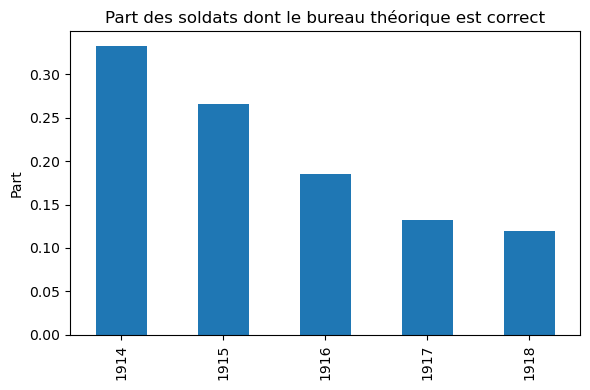

In [661]:
a = d.groupby(["annee_mort","bureau_origine_true"])["id"].count().unstack()
a["share"] = a[1]/a.sum(axis=1)

ax = a["share"].plot(kind='bar', figsize=(6, 4), title='Part des soldats dont le bureau théorique est correct', xlabel='', ylabel='Part', legend=False)
plt.tight_layout()
plt.savefig("part_soldats_bureaucorrect.png")

#### Comparaison de la part des soldats morts à Verdun sous Pétain en fonction du statut théorique VerdunPétain/notVertdunPétain du bureau de recrutement des soldats

In [662]:
tabulate_petain = df.pivot_table(index="bureau_verdun_petain", columns="verdun_petain",values="id",aggfunc="count")
tabulate_petain["part soldat"] = tabulate_petain["1"]/tabulate_petain.sum(axis=1)*100
tabulate_petain

verdun_petain,0,1,part soldat
bureau_verdun_petain,,,
0,249459,3824,1.509774
1,194441,5812,2.902329


Interprétation : 2,90% de tous soldats morts pendant la guerre dont le bureau de recrutement réel est censé avoir envoyé des soldats à Verdun sous Pétain sont effectivement morts à Verdun sous Pétain, contre 1,18% des soldats dont le bureau de recrutement est censé ne pas avoir envoyé de soldats à Verdun sous Pétain.

In [663]:
df.to_csv("mpf_petainverdun.csv",index=False)

with pd.ExcelWriter('donnees_auxiliaires.xlsx') as writer:  
    df_bureau.to_excel(writer, sheet_name='bureaux_regiments',index=False)
    df_regim_verdun.to_excel(writer, sheet_name='regiments_verdun',index=False)
    bureau_petain.to_excel(writer, sheet_name='bureaux_petain',index=False)